In [50]:
import pandas as pd
import rdkit
from rdkit import Chem
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.featurizer import MordredFeaturizer

In [51]:
# Load the dataset

df = 'results/taar1_mixed/8WCA/8WCA_CNS.csv'
df = pd.read_csv(df)
df.head()

,path,molecule,proxy,target,qed,pka,num_reactions,num_non_unary_reactions,mode,similarity,ligand,ligand_relation,ligand_value,ligand_units,ligand_type,ligand_target,ligand_target_name
0,"['Cc1cccc2c1C[C@@H]1[C@@H](C(=O)O)[C@H]21', ('...",Cc1cccc2c1C[C@@H]1[C@@H](CN3Cc4ccc(Cl)cc4C[C@H...,10.185202,10.8,0.889389,1.0,1,1,0,0.337209,Cc1cc(CN2Cc3ccccc3C[C@@H]2C(=O)Nc2ccc(Cl)cc2Cl...,['='],[0.8],['uM'],['EC50'],['CHEMBL235'],['Peroxisome proliferator-activated receptor g...
1,"['Cc1cccc2c1C[C@@H]1[C@@H](C(=O)O)[C@H]21', ('...",Cc1cccc2c1C[C@@H]1[C@@H](CN3CCOC[C@@H]3c3ccc4c...,10.126924,11.1,0.832356,1.0,1,1,1,0.362319,Cc1cccc(N2CCN(Cc3ccc4c(c3)OCO4)CC2)c1C,[nan],[28.1838],['uM'],['Potency'],['CHEMBL1784'],['Glucagon-like peptide 1 receptor']
2,"['CN1CCc2cc([C@H]3C[C@@H]3N)ccc21', ('[Nh2:5]-...",CN1CCc2cc([C@H]3C[C@@H]3NC(=O)NC3CCC(F)(F)c4cc...,10.037493,11.2,0.803183,1.0,1,1,2,0.400000,O=C(Cc1ccccc1)N1CCc2cc(C3CC3NCC3CCNCC3)ccc21,['>'],[100.0],['uM'],['IC50'],['CHEMBL2039'],['Monoamine oxidase B']
3,"['O=C(O)[C@H]1Cc2c(F)cccc21', ('[C:1](=[O])[Oh...",Oc1ccc2c(c1)[C@@H](NC[C@H]1Cc3c(F)cccc31)CC1(C...,10.034279,10.9,0.847460,1.0,2,1,3,0.375000,CS(=O)(=O)Nc1ccc(CNC(=O)NC2CC3(CCCC3)Oc3ccccc3...,['='],[1280.0],['nM'],['IC50'],['CHEMBL4794'],['Vanilloid receptor']
4,"['Cc1cccc2c1C[C@@H]1[C@@H](C(=O)O)[C@H]21', ('...",Cc1cccc2c1C[C@@H]1[C@@H](CN3C[C@H](c4ccccc4)NC...,10.010732,10.5,0.908977,1.0,1,1,4,0.328125,Cc1cccc2c1CN(C)CC2c1ccccc1,['='],[276.0],['nM'],['Ki'],['CHEMBL238'],['Dopamine transporter']


In [60]:
# classify molecules by BBB permeability

from src.featurizer.featurizer import EcfpFeaturizer, MordredFeaturizer
from src.predictor.scikit import SvmClassifier, RfClassifier, PredictorBase

MODEL_PATH = 'models/RF_MORDRED_BBBP_PAMPA/model.pkl'

# Init featurizer and model
featurizer = MordredFeaturizer()
model = RfClassifier(target_metric='roc_auc', optimize_hyperparameters=True, optimization_iterations=10, n_folds=5, n_jobs=8)
model.load(MODEL_PATH)
model.inject_featurizer(featurizer)

In [61]:
predictions = model.predict(smiles_list)
df['BBBP_prediction'] = predictions

100%|██████████| 5000/5000 [04:25<00:00, 18.85it/s]


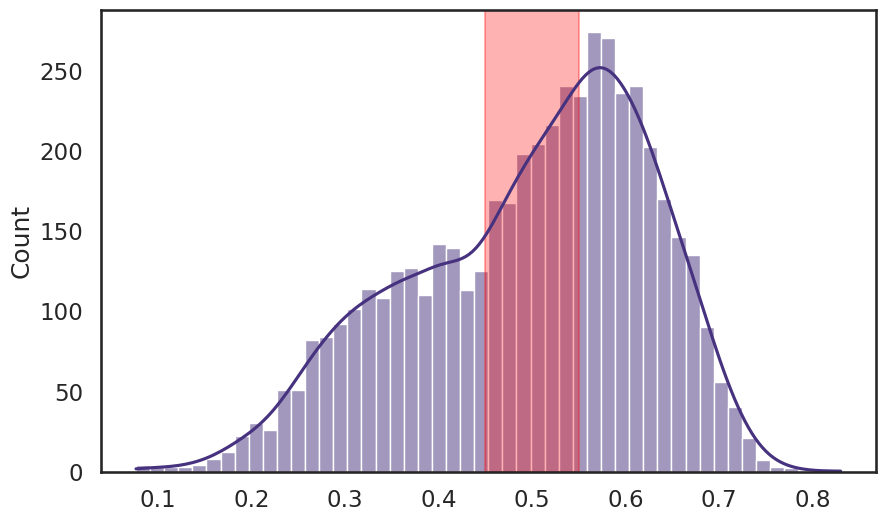

In [66]:
sns.set_style(style="white")
sns.set_context("talk")
sns.set_palette("viridis")
plt.figure(figsize=(10, 6))
sns.histplot(predictions, bins=50, kde=True)
plt.axvspan(0.45, 0.55, color='red', alpha=0.3)

In [72]:
# draw top 10 molecules with highest predicted probability of being BBB permeable
from rdkit.Chem import Draw
from rdkit.Chem import rdDepictor
from ipywidgets import interact, widgets
from rdkit.Chem.Draw import rdMolDraw2D

top_100 = df.nlargest(100, 'BBBP_prediction')

#interactive widget to draw top molecules

@interact
def draw_top_molecules(i=widgets.IntSlider(min=0, max=90, step=10)):
    mols = [Chem.MolFromSmiles(smi) for smi in top_100['molecule']][i:i+10]
    [rdDepictor.Compute2DCoords(mol) for mol in mols if mol is not None]  # Ensure 2D coordinates are computed
    [rdDepictor.StraightenDepiction(mol) for mol in mols if mol is not None]  # Straighten depiction
    legends = [str(x) for x in top_100['BBBP_prediction'].round(2).tolist()][i:i+10]
    return Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200, 200), useSVG=True, legends=legends)

interactive(children=(IntSlider(value=0, description='i', max=90, step=10), Output()), _dom_classes=('widget-i…

In [78]:
bottom_100 = df.nsmallest(100, 'BBBP_prediction')

@interact
def draw_top_molecules(i=widgets.IntSlider(min=0, max=90, step=10)):
    mols = [Chem.MolFromSmiles(smi) for smi in bottom_100['molecule']][i:i+10]
    [rdDepictor.Compute2DCoords(mol) for mol in mols if mol is not None]  # Ensure 2D coordinates are computed
    [rdDepictor.StraightenDepiction(mol) for mol in mols if mol is not None]  # Straighten depiction
    legends = [str(x) for x in bottom_100['BBBP_prediction'].round(2).tolist()][i:i+10]
    return Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200, 200), useSVG=True, legends=legends)

interactive(children=(IntSlider(value=0, description='i', max=90, step=10), Output()), _dom_classes=('widget-i…